# Time Series Project

## Introduction

This project contain a data of taxi orders at airports. The aim of this project is to predict the number of taxi orders for the next hours, to attract more drivers at peak hours.

### Libraries Import

In [1]:
# Data calculation and analysis libraries
import pandas as pd
import numpy as np
import sidetable as stb
import math 

# A function which breaks the time series into three components: trend, seasonality, and residuals
from statsmodels.tsa.seasonal import seasonal_decompose

# Libraries for plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Splitting data function
from sklearn.model_selection import train_test_split

# MSE model evaluetion function
from sklearn.metrics import mean_squared_error

# Cross-validation function
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Factory function that wraps scoring functions for use in cross_val_score
from sklearn.metrics import fbeta_score, make_scorer

# Regression models
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Gradient - Boosting regression models
import lightgbm as lgb
from catboost import CatBoostRegressor

# A hyperparameter optimization framework to automate hyperparameter search
import optuna

# Ignoring warnings library
import warnings
warnings.filterwarnings('ignore')

### 1. Download the data and resample it by one hour.

In [2]:
# Opening the data file and setting the 'datetime' column as the table index and changing its type to datetime64
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# Checking if the dates and times are chronologically ordered
df.index.is_monotonic

True

The dates and times are chronologically ordered.

In [4]:
# Resampling the data by one hour
df = df.resample('1H').sum()

In [5]:
# Reviewing the first five rows after resampling the data
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


The data was resampled correctly.

### 2. Analyze the data.

In [6]:
# Calling the info() method to see general information of the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


We see that there is one column for the number of taxi orders. Also, we know that we have 4,416 aggregated observations and no missing values (we will verify it also with the sidetable library in the next step). 

**Missing values**

In [7]:
# Double checking for missing values
df.stb.missing(style = True)

,missing,total,percent
num_orders,0,"4,416",0.00%


No missing values as we expected :)

**Orders distribution**

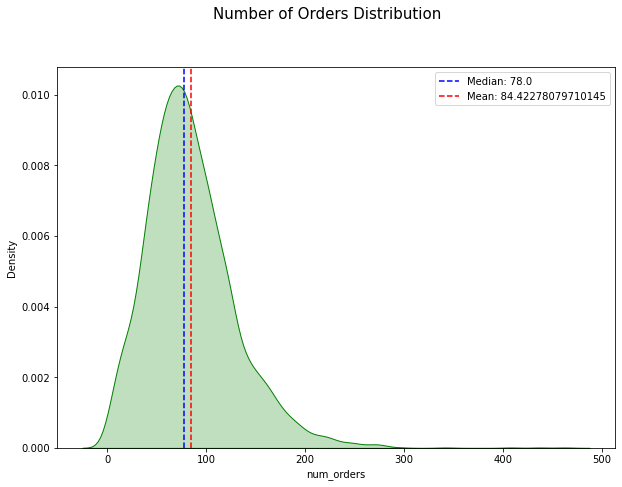

In [8]:
fig = plt.figure(figsize =(10, 7))
fig.suptitle('Number of Orders Distribution', fontsize=15, y=1)
sns.kdeplot(df['num_orders'], fill = True, color = 'green')

plt.axvline(x = df['num_orders'].median(),
            color='blue',
            ls='--', 
            lw=1.5, 
            label = 'Median: {}'.format(df['num_orders'].median()))

plt.axvline(x = df['num_orders'].mean(),
            color='red',
            ls='--', 
            lw=1.5, 
            label = 'Mean: {}'.format(df['num_orders'].mean()))
plt.legend()
plt.show()

We see that the distribution has a slight skew to the right, it's because we have a large number of orders that gets up to 200 - 300 per hour, which pooling the distribution to the right. We can also see it in the values of the median and the mean, the median has a smaller value than the mean because it is less sensitive to extreme values. The large numbers are pooling the mean up, and this is why the mean has a greater value than the median.

**Time Series graph**

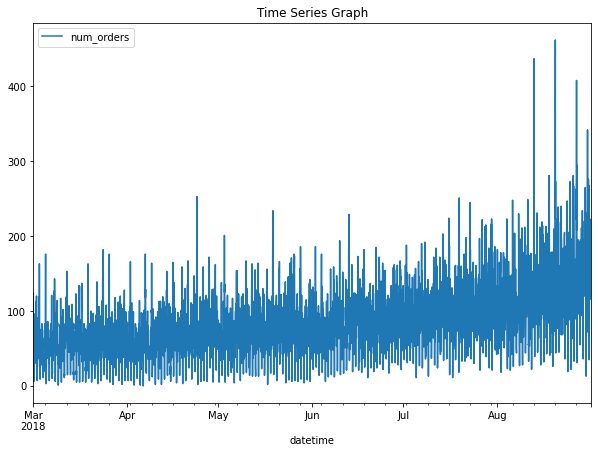

In [9]:
df.plot(figsize =(10, 7), title = 'Time Series Graph')
plt.show()

We see that the time series has a positive linear trend. In the next step, we will smooth the data with a  rolling mean to reduce the fluctuations and get a more clear understanding of the time series data.

**Trends and seasonality**

Let's check the trends and the seasonality to better understand the time series. In the beginning, we resampled the data by one hour, but for the purposes of our little analysis in this stage, we will resample the data by one day. Doing so will solve our problem with missing data points that we receive with one hour resample. 

In [10]:
# Resampling the data by one day
df_d = df.resample('1D').sum()

In [11]:
# Decomposing the time series
decomposed = seasonal_decompose(df_d)

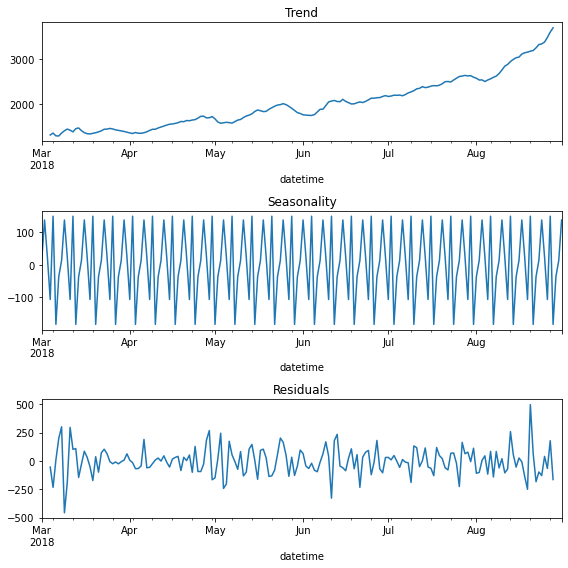

In [12]:
plt.figure(figsize=(8, 8))
plt.subplot(311)
# To display the graph correctly, specify its
# axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

We see that the trend is pretty much linear, and the demand for taxi drivers at airports is strat rising in May. We see that in summer times, the demand for taxi drivers is the highest when August is the most profitable month with double amount of orders than in March-April. In seasonality, we see that the number of orders per day varies between +150 and -150 for all the time periods. 

In [13]:
# Decomposing the time series
decomposed_h = seasonal_decompose(df, period = 1)

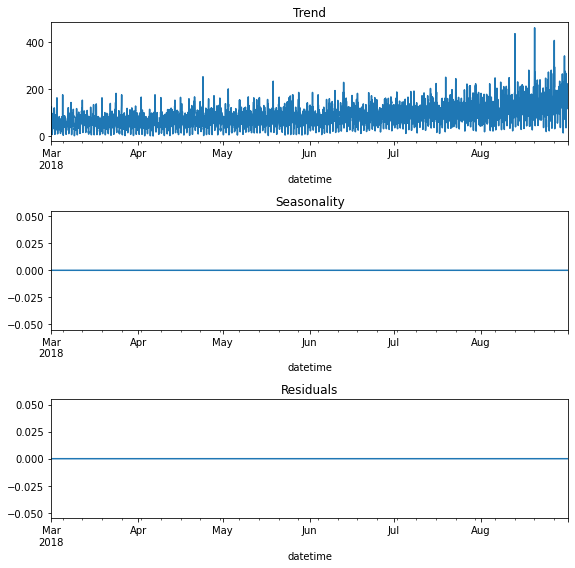

In [14]:
plt.figure(figsize=(8, 8))
plt.subplot(311)
# To display the graph correctly, specify its
# axes ax equal to plt.gca() (gca = get current axis)
decomposed_h.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_h.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_h.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

### 3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset.

In [15]:
# Creating the 'make_features' function to add calendar, lag and rolling mean features to the dataset
def make_features(data_frame, max_lag, rolling_mean_size):
    data = data_frame
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for i in range(1, max_lag + 1):
        data['lag_{}'.format(i)] = data['num_orders'].shift(i)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )
    return data

In [16]:
# Passing arguments to the make_features function 
df_features = make_features(df, 25, 10)

In [17]:
# Splitting the dataset and dropping the missing values from the train set
train, test = train_test_split(df_features, shuffle=False, test_size=0.1, random_state = 12345)
train = train.dropna()

In [18]:
# Setting the features and target variables for train and test sets

# Train
features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']

# Test
features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

In [19]:
# Setting an empty list for the RMSE values
rmse = []

**Linear Regression - Lasso Regressor**

In [20]:
# Creating an objective function to train and evaluate the model
def objective_lasso(trial):
    
    # hyperparameter setting
    alpha = trial.suggest_uniform('alpha', 0.0, 2.0)
    
    # model training and evaluation
    model = Lasso(alpha=alpha)
    model.fit(features_train, target_train)
    pred = model.predict(features_train)
    rmse_score = math.sqrt(mean_squared_error(target_train, pred))

    # output: evaluation score
    return rmse_score

In [21]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective_lasso, n_trials = 100)

lasso_best_params = study.best_params
print('Minimum mean squared error: ', study.best_value)
print('Best parameter: ', study.best_params)
rmse.append(study.best_value)

Minimum mean squared error:  25.775943231934473
Best parameter:  {'alpha': 0.0002627156536837115}
CPU times: user 30 s, sys: 6.1 s, total: 36.1 s
Wall time: 4.81 s


**Decision Tree**

In [22]:
# Creating an objective function to train and evaluate the model
def objective_tree(trial):
    
    # hyperparameter setting
    max_depth = trial.suggest_int('max_depth', 5, features_train.shape[1])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    min_impurity_decrease = trial.suggest_uniform('min_impurity_decrease', 0.01, 0.2)
    
    # model training and evaluation
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split = min_samples_split, 
                                 min_samples_leaf = min_samples_leaf, min_impurity_decrease = min_impurity_decrease,
                                 random_state = 12345)
    model.fit(features_train, target_train)
    pred = model.predict(features_train)
    rmse_score = math.sqrt(mean_squared_error(target_train, pred))

    # output: evaluation score
    return rmse_score

In [23]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective_tree, n_trials = 100)

tree_best_params = study.best_params
print('Minimum mean squared error: ', study.best_value)
print('Best parameter: ', study.best_params)
rmse.append(study.best_value)

Minimum mean squared error:  8.088735722737743
Best parameter:  {'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.09231211099083309}
CPU times: user 6.58 s, sys: 324 ms, total: 6.91 s
Wall time: 5.83 s


**Random Forest**

In [24]:
# Creating an objective function to train and evaluate the model
def objective_forest(trial):
    
    # hyperparameter setting
    max_depth = trial.suggest_int('max_depth', 4, 50)
    min_impurity_decrease = trial.suggest_uniform('min_impurity_decrease',0.01, 0.2)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 6)
    
    # model training and evaluation
    model = DecisionTreeRegressor(max_depth=max_depth, min_impurity_decrease = min_impurity_decrease, 
                                  min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf,
                                 random_state = 12345)
    model.fit(features_train, target_train)
    pred = model.predict(features_train)
    rmse_score = math.sqrt(mean_squared_error(target_train, pred))

    # output: evaluation score
    return rmse_score

In [25]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective_forest, n_trials = 100)

forest_best_params = study.best_params
print('Minimum mean squared error: ', study.best_value)
print('Best parameter: ', study.best_params)
rmse.append(study.best_value)

Minimum mean squared error:  6.493547351374799
Best parameter:  {'max_depth': 43, 'min_impurity_decrease': 0.010485998292168886, 'min_samples_split': 4, 'min_samples_leaf': 2}
CPU times: user 6.22 s, sys: 11.8 ms, total: 6.23 s
Wall time: 6.23 s


**LightGBM Regressor**

In [26]:
# Creating an objective function to train and evaluate the model
def objective_lgbm(trial):
    
    # hyperparameter setting
    max_depth = trial.suggest_int('max_depth', 4, 50)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_uniform('learning_rate',0.01, 1)
    min_split_gain = trial.suggest_int('min_split_gain', 2, 20)
    
    # model training and evaluation
    model = lgb.LGBMRegressor(max_depth=max_depth, n_estimators = n_estimators, 
                                  learning_rate = learning_rate, min_split_gain = min_split_gain,
                                 random_state = 12345)
    model.fit(features_train, target_train)
    pred = model.predict(features_train)
    rmse_score = math.sqrt(mean_squared_error(target_train, pred))

    # output: evaluation score
    return rmse_score

In [27]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective_lgbm, n_trials = 100)

lgbm_best_params = study.best_params
print('Minimum mean squared error: ', study.best_value)
print('Best parameter: ', study.best_params)
rmse.append(study.best_value)

Minimum mean squared error:  0.8648872229875573
Best parameter:  {'max_depth': 14, 'n_estimators': 131, 'learning_rate': 0.9936038373514103, 'min_split_gain': 2}
CPU times: user 1min 31s, sys: 6.55 s, total: 1min 38s
Wall time: 12.7 s


**CatBoost Regressor**

In [28]:
# Creating an objective function to train and evaluate the model
def objective_cat(trial):
    
    # hyperparameter setting
    max_depth = trial.suggest_int('max_depth', 4, 16)
    n_estimators = trial.suggest_int('n_estimators', 150, 200)
    
    # model training and evaluation
    model = CatBoostRegressor(max_depth=max_depth, n_estimators = n_estimators,  
                                 random_state = 12345, verbose = 0)
    model.fit(features_train, target_train)
    pred = model.predict(features_train)
    rmse_score = math.sqrt(mean_squared_error(target_train, pred))

    # output: evaluation score
    return rmse_score

In [29]:
%%time

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective_cat, n_trials = 5)

cat_best_params = study.best_params
print('Minimum mean squared error: ', study.best_value)
print('Best parameter: ', study.best_params)
rmse.append(study.best_value)

Minimum mean squared error:  0.47468147966907814
Best parameter:  {'max_depth': 15, 'n_estimators': 199}
CPU times: user 11min 2s, sys: 5min 19s, total: 16min 21s
Wall time: 2min 47s


In [30]:
# Creating a list with model names
models_names = ['Lasso Regressor', 'Decision Tree Regressor', 'Random Forest Regressor', 
                'LightGBM Regressor', 'CatBoost Regressor']

In [31]:
# Creating DataFrame with the difrrenet models scores
df_models_scores = pd.DataFrame(rmse, index = models_names)
df_models_scores.columns = ['RMSE']
df_models_scores = df_models_scores.sort_values(by = 'RMSE')
df_models_scores

,RMSE
CatBoost Regressor,0.474681
LightGBM Regressor,0.864887
Random Forest Regressor,6.493547
Decision Tree Regressor,8.088736
Lasso Regressor,25.775943


We see that as expected, the gradient boosting models have the best results. Now all that is left is to test the models on the test dataset.

### 4. Test the data using the test sample and provide a conclusion.

In [32]:
# Setting empty list for the test RMSE results
rmse_test = []

**Lasso Regressor**

In [33]:
# Setting the model with the best hyperparameters 
lasso_best_model = Lasso(alpha = lasso_best_params['alpha'])

# Training the regressor
lasso_best_model.fit(features_train, target_train)

# Testing the algorithm with the test dataset
pred_lasso = lasso_best_model.predict(features_test)

# Calculating the RMSE for the test dataset
rmse_test_lasso = math.sqrt(mean_squared_error(target_test, pred_lasso))
rmse_test.append(rmse_test_lasso)
print('Final RMSE score of the Lasso Regressor for the test dataset:',rmse_test_lasso)

Final RMSE score of the Lasso Regressor for the test dataset: 45.671255770304626


**Decision Tree Regressor**

In [34]:
# # Setting the model with the best hyperparameters 
tree_best_model = DecisionTreeRegressor(max_depth = tree_best_params['max_depth'], 
                                   min_impurity_decrease = tree_best_params['min_impurity_decrease'], 
                                    min_samples_split = tree_best_params['min_samples_split'],
                                    min_samples_leaf = tree_best_params['min_samples_leaf'],
                                   random_state = 12345)

# Training the regressor
tree_best_model.fit(features_train, target_train)

# Testing the algorithm with the test dataset
pred_tree = tree_best_model.predict(features_test)

# Calculating the RMSE for the test dataset
rmse_test_tree = math.sqrt(mean_squared_error(target_test, pred_tree))
rmse_test.append(rmse_test_tree)
print('Final RMSE score of the Decision Tree Regressor for the test dataset:',rmse_test_tree)

Final RMSE score of the Decision Tree Regressor for the test dataset: 58.65524284196817


**Random Forest Regressor**

In [35]:
# Setting the model with the best hyperparameters 
forest_best_model = RandomForestRegressor(max_depth = forest_best_params['max_depth'], 
                                   min_impurity_decrease = forest_best_params['min_impurity_decrease'], 
                                    min_samples_split = forest_best_params['min_samples_split'],
                                    min_samples_leaf = forest_best_params['min_samples_leaf'],
                                   random_state = 12345)

# Training the regressor
forest_best_model.fit(features_train, target_train)

# Testing the algorithm with the test dataset
pred_forest = forest_best_model.predict(features_test)

# Calculating the RMSE for the test dataset
rmse_test_forest = math.sqrt(mean_squared_error(target_test, pred_forest))
rmse_test.append(rmse_test_forest)
print('Final RMSE score of the Random Forest Regressor for the test dataset:',rmse_test_forest)

Final RMSE score of the Random Forest Regressor for the test dataset: 41.76754206812973


**LightGBM Regressor**

In [36]:
# Setting the model with the best hyperparameters 
lgbm_best_model = lgb.LGBMRegressor(max_depth = lgbm_best_params['max_depth'], 
                                   n_estimators = lgbm_best_params['n_estimators'], 
                                    learning_rate = lgbm_best_params['learning_rate'],
                                    min_split_gain = lgbm_best_params['min_split_gain'],
                                   random_state = 12345)

# Training the regressor
lgbm_best_model.fit(features_train, target_train)

# Testing the algorithm with the test dataset
pred_lgbm = lgbm_best_model.predict(features_test)

# Calculating the RMSE for the test dataset
rmse_test_lgbm = math.sqrt(mean_squared_error(target_test, pred_lgbm))
rmse_test.append(rmse_test_lgbm)
print('Final RMSE score of the LightGBM Regressor for the test dataset:',rmse_test_lgbm)

Final RMSE score of the LightGBM Regressor for the test dataset: 52.852778372470354


**CatBoost Regressor**

In [37]:
# Setting the model with the best hyperparameters 
cat_best_model = CatBoostRegressor(max_depth = cat_best_params['max_depth'], 
                                   n_estimators = cat_best_params['n_estimators'], 
                                   random_state = 12345, verbose = 0)

# Training the regressor
cat_best_model.fit(features_train, target_train)

# Testing the algorithm with the test dataset
pred_cat = cat_best_model.predict(features_test)

# Calculating the RMSE for the test dataset
rmse_test_cat = math.sqrt(mean_squared_error(target_test, pred_cat))
rmse_test.append(rmse_test_cat)
print('Final RMSE score of the CatBoost Regressor for the test dataset:',rmse_test_cat)

Final RMSE score of the CatBoost Regressor for the test dataset: 51.716328484904444


In [38]:
# Creating DataFrame with the difrrenet models scores
df_models_scores = pd.DataFrame(rmse_test, index = models_names)
df_models_scores.columns = ['RMSE_test']
df_models_scores = df_models_scores.sort_values(by = 'RMSE_test')
df_models_scores

,RMSE_test
Random Forest Regressor,41.767542
Lasso Regressor,45.671256
CatBoost Regressor,51.716328
LightGBM Regressor,52.852778
Decision Tree Regressor,58.655243


In [39]:
# Creating dictionary with the different predictions
pred_dic = {'true_answers' : target_test,'forest' : pred_forest, 'lasso' : pred_lasso, 'catboost' : pred_cat, 
           'lgbm' : pred_lgbm, 'tree' : pred_tree}

In [40]:
# Creating DataFrame with the different predictions
df_pred = pd.DataFrame(pred_dic).reset_index(drop = True)
df_pred.head()

,true_answers,forest,lasso,catboost,lgbm,tree
0,102,105.862111,118.666948,89.351951,116.599129,76.333333
1,175,127.675381,127.372005,109.469852,103.088204,201.000000
2,144,146.524000,117.347628,142.189846,137.573587,201.000000
3,152,136.529405,98.468303,115.260441,153.531041,177.500000
4,104,101.785121,113.462176,80.706735,141.302841,137.500000


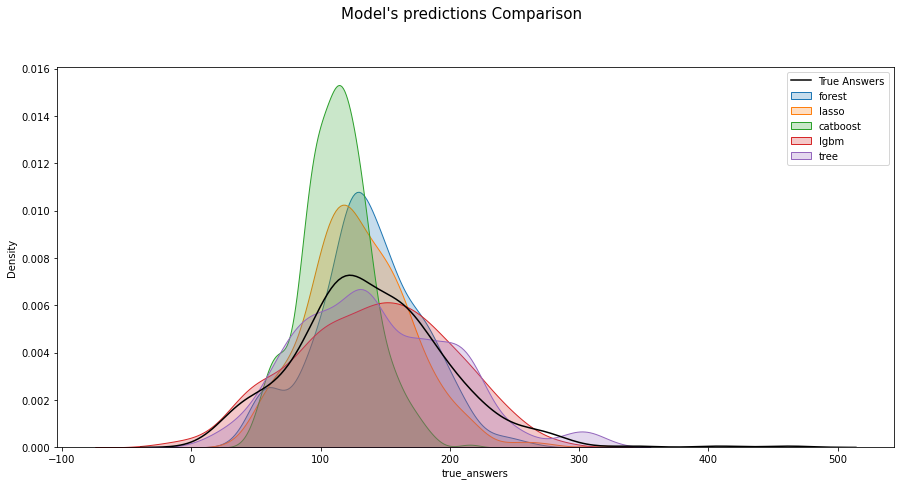

In [41]:
fig = plt.figure(figsize =(15, 7))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle("Model's predictions Comparison", fontsize=15, y=1)
sns.kdeplot(df_pred['true_answers'], label = 'True Answers', color = 'black')
colomns = df_pred.columns
for i in range(1,6):
    sns.kdeplot(df_pred[colomns[i]], label = colomns[i], fill = True)
    
plt.legend()
plt.show()  

**Conclusion**

We see that we met the goal of RMSE score of less than 48. We tried 5 different regression models, while in training the gradient boosting models had the best RMSE scores, in testing, the **Random Forest and the Lasso regressors had the best results of RMSE score less than 48**. Our models can forecast the number of taxi orders with a deviation of 41-45 orders respectively. 